# Facial Emotion Classification

In [197]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.9.1


# Importing Images and Exploring

In [132]:
# Creating directories to each path in the sentiment folder for test data

train_angry_dir = os.path.join('./sentiment/test/angry')
train_disgust_dir = os.path.join('./sentiment/test/disgust')
train_fear_dir = os.path.join('./sentiment/test/fear')
train_happy_dir = os.path.join('./sentiment/test/happy')
train_neutral_dir = os.path.join('./sentiment/test/neutral')
train_sad_dir = os.path.join('./sentiment/test/sad')
train_surprise_dir = os.path.join('./sentiment/test/surprise')

In [133]:
train_angry_names = os.listdir(train_angry_dir)
train_disgust_names = os.listdir(train_disgust_dir)
train_fear_names = os.listdir(train_fear_dir)
train_happy_names = os.listdir(train_happy_dir)
train_neutral_names = os.listdir(train_neutral_dir)
train_sad_names = os.listdir(train_sad_dir)
train_happy_names = os.listdir(train_neutral_dir)
train_surprise_names = os.listdir(train_surprise_dir)

print(train_angry_names[:10])

['PrivateTest_10131363.jpg', 'PrivateTest_10304478.jpg', 'PrivateTest_1054527.jpg', 'PrivateTest_10590091.jpg', 'PrivateTest_1109992.jpg', 'PrivateTest_11296953.jpg', 'PrivateTest_12000629.jpg', 'PrivateTest_12008383.jpg', 'PrivateTest_12191716.jpg', 'PrivateTest_1221822.jpg']


In [136]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

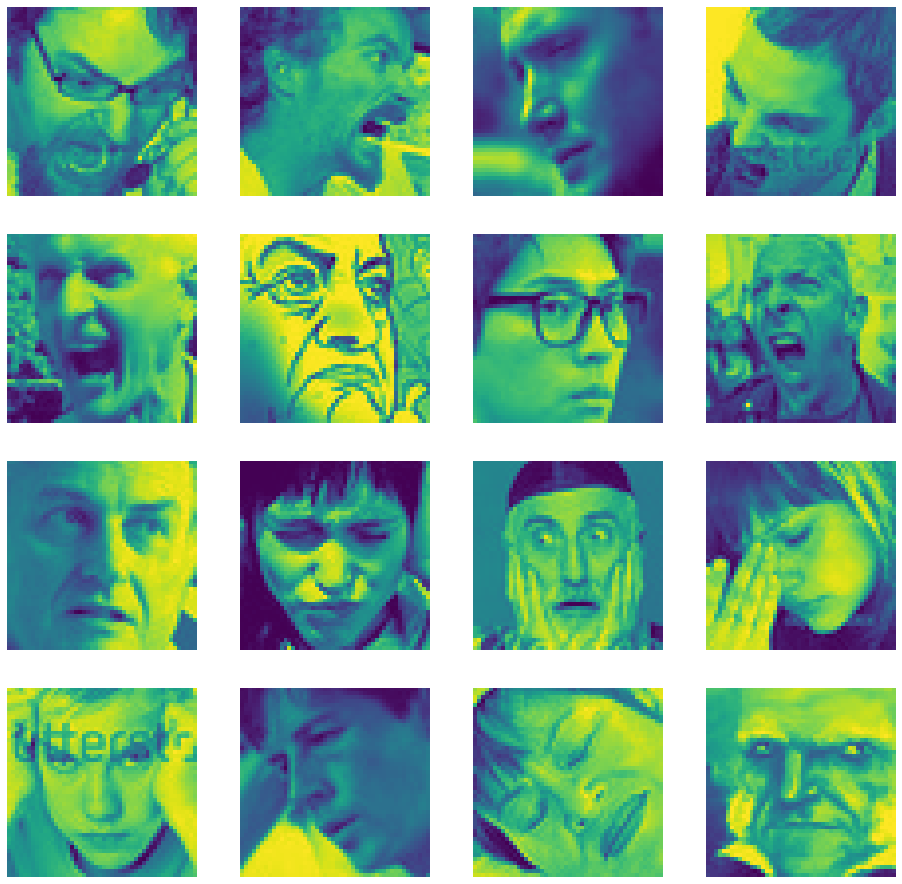

In [137]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_angry_pix = [os.path.join(train_angry_dir, fname) 
                for fname in train_angry_names[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(train_sad_dir, fname) 
                for fname in train_sad_names[pic_index-8:pic_index]]


for i, img_path in enumerate(next_angry_pix+next_sad_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Callback function

In [138]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > .75:
            print("\nReached 75.0% accuracy so cancelling training!")
            self.model.stop_training = True    

# Preprocess Data

In [201]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   rotation_range=15,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        './sentiment/train',  # This is the source directory for training images
        target_size=(48, 48),  
        batch_size=64,
        color_mode = "grayscale",
        class_mode='categorical',
        subset='training',
        shuffle=True)

val_generator = train_datagen.flow_from_directory(
        './sentiment/train',  # This is the source directory for training images
        target_size=(48, 48),  
        batch_size=64,
        color_mode = "grayscale",
        class_mode='categorical',
        subset='validation',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        './sentiment/test',  # This is the source directory for training images
        target_size=(48, 48),  
        batch_size=64,
        color_mode = "grayscale",
        class_mode='categorical')


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Building Small Model

In [202]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 48x48 with 1 bytes color
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=256, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=512, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Flatten the results to feed into a DNN
    Flatten(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(7, activation='softmax')
])

In [203]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [204]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [205]:
callback = myCallback()

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
      train_generator, 
      epochs=70,
      verbose=1,
      validation_data = val_generator,
      callbacks=[callback, lr_scheduler, early_stopping])

Epoch 1/70
359/359 [==============================] - 15s 39ms/step - loss: 2.0904 - accuracy: 0.2122 - val_loss: 1.9888 - val_accuracy: 0.1677 - lr: 5.0000e-04
Epoch 2/70
359/359 [==============================] - 14s 38ms/step - loss: 1.9122 - accuracy: 0.2331 - val_loss: 1.8542 - val_accuracy: 0.2581 - lr: 5.0000e-04
Epoch 3/70
359/359 [==============================] - 14s 38ms/step - loss: 1.8200 - accuracy: 0.2703 - val_loss: 1.9005 - val_accuracy: 0.2355 - lr: 5.0000e-04
Epoch 4/70
359/359 [==============================] - 14s 39ms/step - loss: 1.7221 - accuracy: 0.3193 - val_loss: 1.8254 - val_accuracy: 0.3033 - lr: 5.0000e-04
Epoch 5/70
359/359 [==============================] - 14s 39ms/step - loss: 1.6426 - accuracy: 0.3557 - val_loss: 1.6601 - val_accuracy: 0.3482 - lr: 5.0000e-04
Epoch 6/70
359/359 [==============================] - 15s 41ms/step - loss: 1.5727 - accuracy: 0.3801 - val_loss: 1.6032 - val_accuracy: 0.3931 - lr: 5.0000e-04
Epoch 7/70
359/359 [==============

Epoch 49/70
359/359 [==============================] - 14s 39ms/step - loss: 1.0050 - accuracy: 0.6206 - val_loss: 1.0055 - val_accuracy: 0.6152 - lr: 6.2500e-05
Epoch 49: early stopping


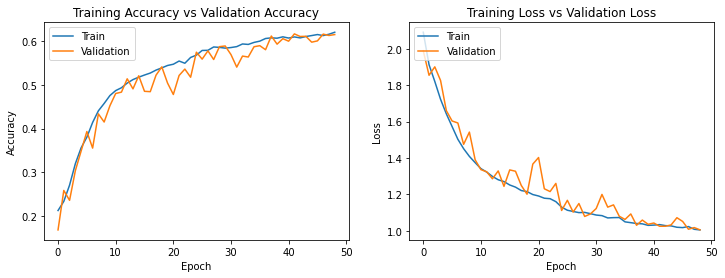

In [206]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [207]:
# from PIL import Image

# # Load and preprocess the new image
# new_image = Image.open('./rein-dj/test/rein-test/rein1.png')
# new_image = new_image.resize((48, 48))
# new_image = new_image.convert('L')
# new_image = np.array(new_image) / 255.0
# new_image = np.expand_dims(new_image, axis=0)

# # Display the image
# plt.imshow(new_image[0])
# plt.axis('off')
# plt.show()

In [208]:
# # Use the trained model to predict the output
# predictions = model.predict(new_image)

# predictions[0]

In [209]:
# train_generator.class_indices
# label_dict = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']

In [210]:
# res = np.argmax(predictions[0])

In [211]:
# print('predicted Label for that image is: {}'.format(label_dict[res]))